<a name='top'></a>Contents
===
- [Introduction](#intro)

- [Libraries](#libraries)

- [Functions](#functions)

- [Settings](#settings)

- [Dataset](#dataset)
      
- [Exploratory data analysis](#exploratory)
    - [Numerical and Categorical data features](#exploratory_features)
    - [Missing values](#exploratory_missing)
    - [Describe Numerical Data](#exploratory_describe_numerical)
    - [Describe Categorical Data](#exploratory_describe_categorical)
    - [Distribution of Target Variable](#distribution_target)
    - [Distribution of logarithm target variable](#distribution_target_log)
    - [Target distribution by categorical values](#distribution_target_categorical)
        - [Target distribution by cat_price](#distribution_target_catprice)
        - [Target distribution by CatN1](#distribution_target_catn1)
    - [Distribution of numerical features](#distribution_columns)
        - [Skewness and kurtosis of numerical features](#skewness_columns)
        - [Logarithm to numerical features](#logarithm_columns)
    - [Distribution of numerical features with target variable](#relation_numerical_columns)
    - [Distribution of categorical features with target variable](#relation_categorical_columns)
    
    
- [Data wrangling](#data_wrangling)
    - [Correlation](#data_correlation)
        - [Correlation of numerical features to target variable](#data_correlation_numerical_original)
        - [Correlation of categorical features to target variable](#data_correlation_categorical_original)
    - [Feature Selection](#data_feature_selection)
        - [Pearson](#data_pearson)
        - [Random Forest](#data_random_forest)    
        - [LGBMRegressor](#data_LGBMRegressor)
        - [Final Feature Selection](#data_final_feature_selection)
    - [Outliers](#outliers)
    - [Correlation feature selection](#correlation_feature_selection)
    - [Distribution of feature selection with target](#distribution_feature_selection)
    - [Multicollinearity](#multicollinearity)
    - [StandardScaler](#standardscaler)
    - [Grade Percentile of target variable](#grade_percentile_target)
    - [Correlation and Distribution final dataset](#distribution_final_dataset)
    

- [Regression Models](#regression_models)
    - [KNeighbors Regressor](#knn)
    - [Linear Regression](#mlr)
    - [Ridge](#ridge)
    - [Lasso](#lasso)
    - [Elastic Net](#enet)
    - [SGD Regressor](#sgd)
    - [Decision Tree Regressor](#dtr)
    - [Gradient Boosting Regressor](#gbr)
    - [Random Forest Regressor](#rfr)

------------------------------------------------------------------------------------------------------
<a name='intro'></a>
# Introduction

EXPLICAR TODO Y PONER FOTO

# RELLENAR!!

PASOS CUBIERTOS
    * DATASET
    * EXPLORATORY DATA ANALYSIS
    * DATA WRANGLING
    * ALGORITHMS

-----------------------------------------------------------------------------------
<a name='libraries'></a>
# Libraries

First of all, it is necessary to import the required libraries to develop all the steps correctly of this notebook.

In [1]:
#import standard libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from scipy import stats
%matplotlib inline
sns.set()


#import libraries for data wrangling
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler


#import model libraries
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import math


#import filter warnings
import warnings
warnings.filterwarnings('ignore')


#display a maximum of 500 columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#set directory of work
path = '/home/miguel/my_project_python/my_project_env/tfm/shopping'
os.chdir(path)

# IMPORTAR LIBRERIAS DE SKLEARN!!!

-----------------------------------------------------------------------------------------------
<a name='functions'></a>
# Functions
In this chapter is run the functions used in this notebook.

In [2]:
#print categorical columns
def columns_categorical(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print('\nColumn Name:', col,)
            print(df[col].value_counts())
            
            
            
#correlation heatmap
def plot_correlation_heatmap(df, number_columns, arg):
    
    #calculate correlation
    corr = df.corr()
    corr_abs = corr.abs()
    columns = corr_abs.nlargest(number_columns, arg)[arg].index
    cont = np.corrcoef(df[columns].values.T)

    #plot values
    plt.figure(figsize = (number_columns, number_columns))
    sns.set(font_scale = 1.5)
    sns.heatmap(cont, linewidths=1.5, annot=True, square=True, fmt='.2f', 
                annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    
    #show
    plt.show()
    

#pearson selector
def pearson_selector(feature_name, X, y):
    
    #create empty dataframe
    correlation_list = []
    
    #calculate the correlation for for each feature with target variable
    for i in feature_name:
        corr = np.corrcoef(X[i], y)[0, 1]
        correlation_list.append(corr)
        
    #fillna nan values with 0
    correlation_list = [0 if np.isnan(i) else i for i in correlation_list]
    
    #feature correlation
    corr_feature = X.iloc[:,np.argsort(np.abs(correlation_list))[-15:]].columns.tolist()
    
    #asign value
    corr_support = [True if i in corr_feature else False for i in feature_name]
    
    return corr_support, corr_feature

-----------------------------------------------------------------------------------------------
<a name='settings'></a>
# Settings

It is established the fixed parameters which will be developed in the notebooK.

In [3]:
#set kurtosis and swekness values
kurt = 2
sw = 2

# set number of cross validations
nr_cv = 3

#number estimators
nr_est = 20

-----------------------------------------------------------------------------------------------
<a name='dataset'></a>
# Dataset

It is opened the dataset of study.

In [4]:
#open the dataset of study
df = pd.read_pickle('./data/final/data_final_ROAS_SI.pkl')

Check the data

In [5]:
df.head()

,CatN1,CatN2,Cat_Price,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads,ROAS
129,muebles,"consolas, recibidores y tocadores",200.0,0.0,0.0,0.0,0.0,0.0,8.0,1.14,0.57,0.38,0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,21.29,15.93,11.05,11.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,147.27,85.32,64.67,54.35,0.0,1.00,0.57,0.43,0.36,0.0,0.0
130,muebles,"consolas, recibidores y tocadores",200.0,0.0,0.0,0.0,0.0,0.0,54.0,8.86,4.43,2.95,2.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,25.29,16.57,12.38,10.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.27,168.31,95.84,71.69,59.61,1.0,1.14,0.64,0.48,0.39,0.0,0.0
131,muebles,"consolas, recibidores y tocadores",200.0,0.0,0.0,0.0,0.0,0.0,51.0,16.14,8.07,5.38,4.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.57,16.57,12.38,10.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,168.31,95.84,71.69,59.61,0.0,1.14,0.64,0.48,0.39,0.0,0.0
132,muebles,"consolas, recibidores y tocadores",200.0,0.0,0.0,0.0,0.0,0.0,35.0,21.14,10.57,7.05,5.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,26.57,18.57,14.14,12.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,168.31,84.15,71.69,59.61,0.0,1.14,0.57,0.48,0.39,0.0,0.0
133,muebles,"consolas, recibidores y tocadores",200.0,0.0,0.0,0.0,0.0,0.0,22.0,24.29,12.14,8.10,6.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,25.29,19.29,14.62,12.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,84.15,84.15,71.69,53.77,0.0,0.57,0.57,0.48,0.36,0.0,0.0


In [6]:
df.shape

(6338, 65)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6338 entries, 129 to 209
Data columns (total 65 columns):
CatN1                 6338 non-null object
CatN2                 6338 non-null object
Cat_Price             6338 non-null object
CPC_medio             6338 non-null float64
CPC_medio_1w          6338 non-null float64
CPC_medio_2w          6338 non-null float64
CPC_medio_3w          6338 non-null float64
CPC_medio_4w          6338 non-null float64
Impressions           6338 non-null float64
Impressions_1w        6338 non-null float64
Impressions_2w        6338 non-null float64
Impressions_3w        6338 non-null float64
Impressions_4w        6338 non-null float64
Clics                 6338 non-null float64
Clics_1w              6338 non-null float64
Clics_2w              6338 non-null float64
Clics_3w              6338 non-null float64
Clics_4w              6338 non-null float64
CTR                   6338 non-null float64
CTR_1w                6338 non-null float64
CTR_2w         

-----------------------------------------------------------------------
<a name='exploratory'></a>
# Exploratory data analysis

RELLENAR


<a name='exploratory_features'></a>
## Numerical and Categorical data features

RELLENAR


In [8]:
#number of numerical columns features
numerical_columns = df.dtypes[df.dtypes != 'object'].index
print('Number of NUMERICAL COLUMNS: {} '.format(len(numerical_columns)))

#number of categorical columns features
categorical_columns = df.dtypes[df.dtypes == 'object'].index
print('Number of CATEGORICAL COLUMNS: {} '.format(len(categorical_columns)))

Number of NUMERICAL COLUMNS: 62 
Number of CATEGORICAL COLUMNS: 3 


In [9]:
#names of numerical and categorical columns
print('Numerical columns: {} '.format(df[numerical_columns].columns))
print('-'*228)
print('Categorical columns: {} '.format(df[categorical_columns].columns))

Numerical columns: Index(['CPC_medio', 'CPC_medio_1w', 'CPC_medio_2w', 'CPC_medio_3w',
       'CPC_medio_4w', 'Impressions', 'Impressions_1w', 'Impressions_2w',
       'Impressions_3w', 'Impressions_4w', 'Clics', 'Clics_1w', 'Clics_2w',
       'Clics_3w', 'Clics_4w', 'CTR', 'CTR_1w', 'CTR_2w', 'CTR_3w', 'CTR_4w',
       'Page_Views', 'Page_Views_1w', 'Page_Views_2w', 'Page_Views_3w',
       'Page_Views_4w', 'Cost', 'Cost_1w', 'Cost_2w', 'Cost_3w', 'Cost_4w',
       'Conversions', 'Conversions_1w', 'Conversions_2w', 'Conversions_3w',
       'Conversions_4w', 'All_Conversions', 'All_Conversions_1w',
       'All_Conversions_2w', 'All_Conversions_3w', 'All_Conversions_4w',
       'Ads_Income', 'Ads_Income_1w', 'Ads_Income_2w', 'Ads_Income_3w',
       'Ads_Income_4w', 'Ads_Income_All', 'Ads_Income_All_1w',
       'Ads_Income_All_2w', 'Ads_Income_All_3w', 'Ads_Income_All_4w',
       'Net_Incomes', 'Net_Incomes_1w', 'Net_Incomes_2w', 'Net_Incomes_3w',
       'Net_Incomes_4w', 'Units_sold', 'U

<a name='exploratory_missing'></a>
## Missing values

It is checked if there are missing values in the dataset.

In [10]:
print('Missing values in the dataset: {} '.format(df.isnull().sum().sum()))

Missing values in the dataset: 0 


<a name='exploratory_describe_numerical'></a>
## Describe Numerical Data

RELLENAR


In [11]:
df.describe()

,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads,ROAS
count,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.00000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000
mean,0.255937,0.247206,0.240574,0.235802,0.230902,1314.518776,1298.036291,1288.106482,1283.895191,1284.402815,12.955822,12.716851,12.599183,12.539047,12.514498,0.009797,0.010435,0.010667,0.010756,0.010719,19.836226,19.546606,19.426029,19.379724,19.356019,3.520404,3.432821,3.39456,3.375262,3.365824,0.077146,0.077152,0.078416,0.079482,0.079595,0.255920,0.262531,0.271546,0.281007,0.287725,5.987139,5.910024,5.952829,6.015019,6.046248,10.913152,10.581352,10.432531,10.372572,10.296500,13.171322,13.053163,13.066221,13.106687,13.145540,0.251814,0.248913,0.248807,0.250469,0.249950,2.081278,10.432341
std,0.146109,0.112181,0.108912,0.108176,0.108157,1653.730960,1512.675822,1469.765985,1452.451260,1449.136934,18.242686,16.272332,15.649133,15.348577,15.163717,0.008136,0.006172,0.005625,0.004876,0.004679,26.945863,20.239143,19.058836,18.529270,18.234294,5.378508,4.430742,4.13976,4.002812,3.919539,0.299551,0.155406,0.139149,0.132875,0.127365,0.752554,0.485174,0.463762,0.459365,0.457179,28.793253,12.421092,10.204678,9.322333,8.828725,51.894968,22.244398,17.821649,15.771643,14.511155,41.688295,19.065811,15.670279,14.121293,13.175751,0.710180,0.371159,0.325856,0.305292,0.291797,18.497901,69.217185
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.430000,0.210000,0.140000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180000,0.180000,0.180000,0.170000,0.150000,338.000000,380.290000,383.307500,387.300000,387.462500,2.000000,2.860000,3.000000,3.050000,3.000000,0.005271,0.010000,0.010000,0.010000,0.010000,0.000000,6.710000,7.360000,7.900000,7.960000,0.570000,0.770000,0.79000,0.820000,0.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,3.130000,3.710000,0.000000,0.000000,0.070000,0.092500,0.070000,0.000000,0.000000
50%,0.250000,0.250000,0.250000,0.250000,0.250000,746.000000,781.785000,802.140000,818.075000,835.410000,6.000000,6.710000,6.790000,6.950

<a name='exploratory_describe_categorical'></a>
## Describe Categorical Data

It is showed the values of categorical data and theirs frecuency.


In [12]:
#show values of categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        print('\nColumn Name: {}'.format(column))
        print('{}'.format(df[column].value_counts()))


Column Name: CatN1
muebles                          2971
decoración para tu casa          1000
organización y almacenamiento     600
textil hogar                      533
lámparas e iluminación            532
jardín y terraza                  301
baño                              213
decoración de navidad              87
cocina y comedor                   62
playa y camping                    39
Name: CatN1, dtype: int64

Column Name: CatN2
consolas, recibidores y tocadores        1142
mesitas de noche                          801
percheros                                 600
alfombras de bambú                        533
espejos de pared                          500
mesas de centro y auxiliares              378
espejos de pie y vestidores               349
lámparas de mesita de noche               334
sillas y sillones de jardín y terraza     301
banquetas y bancos                        203
lámparas de mesa                          198
cómodas                                   181
es

<a name='distribution_target'></a>
## Distribution of target variable

It is studied the distribution of the target variable: 'ROAS'

In [13]:
#set target variable
y = df['CTR']

#describe target
y.describe()

count    6338.000000
mean        0.009797
std         0.008136
min         0.000000
25%         0.005271
50%         0.008448
75%         0.012743
max         0.200000
Name: CTR, dtype: float64

Plot the distribution and display its skewness and kurtosis

Skewness: 4.62
Kurtosis: 65.51


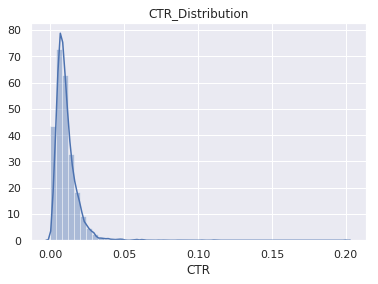

In [14]:
#target distribution
sns.distplot(y).set_title('CTR_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

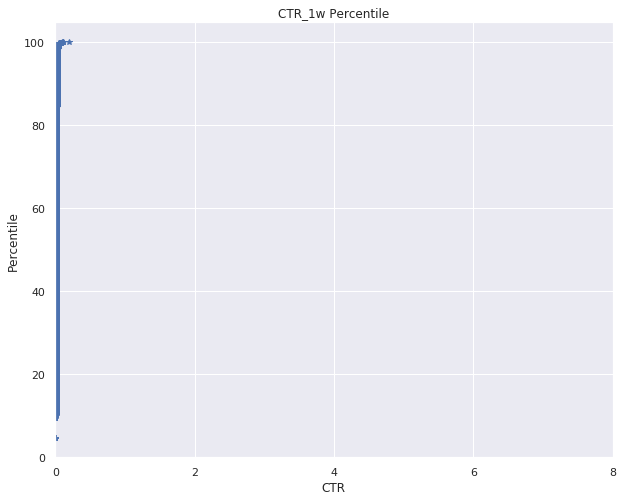

In [15]:
#create percentile
df['percentile'] = df['CTR'].apply(lambda x: percentileofscore(df['CTR'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['CTR'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('CTR')
plt.ylabel('Percentile')
plt.title('CTR_1w Percentile');

In [16]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'CTR']),4)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'CTR']),4)))

Score to achieve 50th percentile: 0.0084
Score to achieve 90th percentile: 0.0185


**¿How is the target variable distributed?**
<br>As we can see from the previous graphs, the target feature is not normally distributed. 
<br>Moreover, the values of Skewness and Kurtosis are not close to their recommendable value: 0 (these values should be near to 0 in order to achieve a normal distribution).

**¿How can affect to the regression models?**
<br>Most of machine learning models assumes the data is normally distributed and if it is not achieve this goal: the performance of the machine learning models cab be reduced dractically (for example: linear regression).

**¿How can it be solved?**
<br>It is necessary to apply log transformation to these variable.

<a name='distribution_target_log'></a>
## Distribution of logarithm target variable 
Then, it is applied logarithm neperian to the target variable

Skewness: 2.02
Kurtosis: 3.52


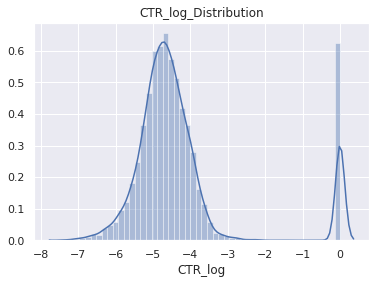

In [17]:
#create log target feature
df['CTR_log'] = np.log(df['CTR'])
df['CTR_log'] = df['CTR_log'].replace([np.inf, -np.inf], np.nan)

df['CTR_log'] = df['CTR_log'].fillna(0)

#drop previous target from dataframe
df.drop('CTR', axis= 1, inplace=True)

#set as new target
y = df['CTR_log']

#target distribution
sns.distplot(y).set_title('CTR_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

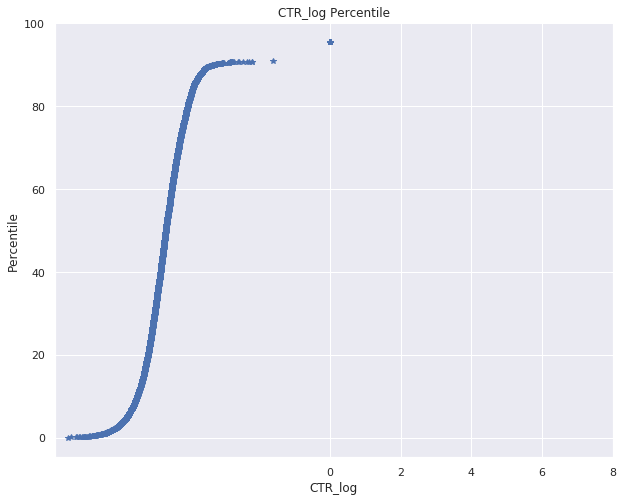

In [18]:
#create percentile
df['percentile'] = df['CTR_log'].apply(lambda x: percentileofscore(df['CTR_log'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['CTR_log'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('CTR_log')
plt.ylabel('Percentile')
plt.title('CTR_log Percentile');

In [19]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'CTR_log']),2)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'CTR_log']),2)))

Score to achieve 50th percentile: -4.63
Score to achieve 90th percentile: -3.23


**¿How is the new target variable distributed?**
<br>As we can observe in the graph, the new target variable is positive skewed (the mean is on the right of the peak) but closer to a normal distribution with mean equal to 0.
<br>In addtion, the values of Skewness and Kurtosis are currently also closer to their recommended scores.



In [20]:
y.describe()

count    6338.000000
mean       -4.279780
std         1.490809
min        -7.409136
25%        -5.037962
50%        -4.634527
75%        -4.151259
max         0.000000
Name: CTR_log, dtype: float64

<a name='distribution_target_categorical'></a>
## Target distribution by categorical values

In this chapter, it is studied the distribution of the categorical features with the target variable.

<a name='distribution_target_catprice'></a>
### Target distribution by cat_price
Distribution of cat_price with ROAS_log.
<br> In this case it is necessary to apply this feature as categorical type.

In [21]:
#set as categorical
df['Cat_Price'] = pd.Categorical(df.Cat_Price,categories=["20.0", "30.0", "40.0", "50.0", "60.0", "80.0", 
                                                          "100.0", "150.0","200.0", "300.0"], ordered=True)

Plot the boxplot

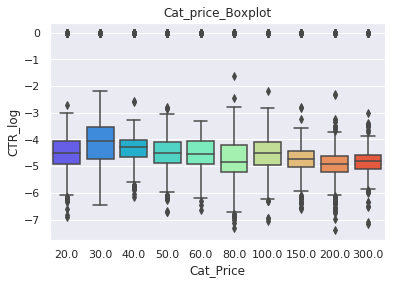

In [22]:
cat_sns1 = sns.boxplot(x='Cat_Price', y='CTR_log', data=df, palette='rainbow').set_title('Cat_price_Boxplot')

RELLENAR!

Plot the violin plot

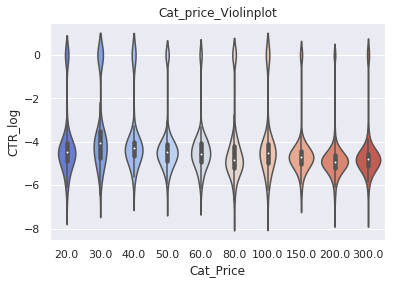

In [23]:
cat_sns2 = sns.violinplot(x='Cat_Price', y='CTR_log', data=df, palette='coolwarm').set_title('Cat_price_Violinplot')

RELLENAR!

<a name='distribution_target_catn1'></a>
### Target distribution by CatN1
Distribution of category N1 with ROAS_log. 

Plot the boxplot

[Text(0, 0, 'muebles'),
 Text(0, 0, 'decoración para tu casa'),
 Text(0, 0, 'organización y almacenamiento'),
 Text(0, 0, 'baño'),
 Text(0, 0, 'textil hogar'),
 Text(0, 0, 'lámparas e iluminación'),
 Text(0, 0, 'cocina y comedor'),
 Text(0, 0, 'decoración de navidad'),
 Text(0, 0, 'jardín y terraza'),
 Text(0, 0, 'playa y camping')]

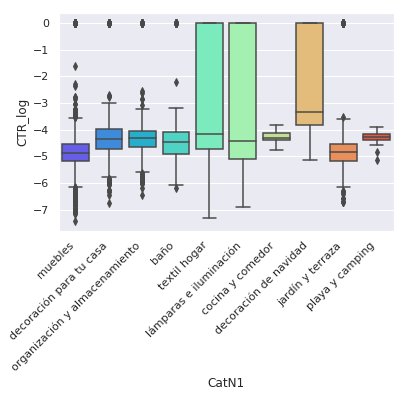

In [24]:
catN1_sns1 = sns.boxplot(x='CatN1', y='CTR_log', data=df, palette='rainbow')
catN1_sns1.set_xticklabels(catN1_sns1.get_xticklabels(), rotation=45, ha='right')

Plot the violin plot

[Text(0, 0, 'muebles'),
 Text(0, 0, 'decoración para tu casa'),
 Text(0, 0, 'organización y almacenamiento'),
 Text(0, 0, 'baño'),
 Text(0, 0, 'textil hogar'),
 Text(0, 0, 'lámparas e iluminación'),
 Text(0, 0, 'cocina y comedor'),
 Text(0, 0, 'decoración de navidad'),
 Text(0, 0, 'jardín y terraza'),
 Text(0, 0, 'playa y camping')]

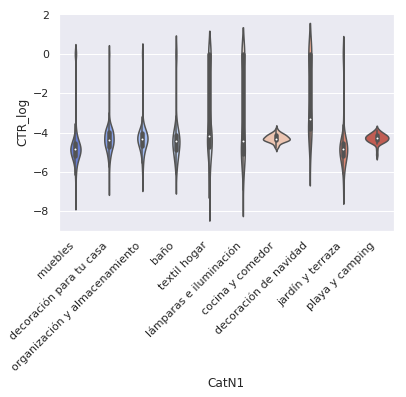

In [25]:
catN1_sns2 = sns.violinplot(x='CatN1', y='CTR_log', data=df, palette='coolwarm')
catN1_sns2.set_xticklabels(catN1_sns2.get_xticklabels(), rotation=45, ha='right')

<a name='distribution_columns'></a>
## Distribution of numerical features

RELLENAR

KURT AND SWEK = 2 DE limite (establexer arriba)

<a name='skewness_columns'></a>
### Skewness and kurtosis of numerical features

RELLENAR


In [26]:
#select index numerical columns
numerical_columns_index = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data = pd.DataFrame([])

for col in numerical_columns_index:
    data = data.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                     'Kurtosis': round(df[col].kurt(),2)}, 
                                    index=[0]), ignore_index=True)

Select categorical and object columns in order to create a dataframe

In [27]:
#filter numerical columns
numerical_columns_dist = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist = pd.DataFrame({'Index':numerical_columns_dist.index, 'Values':numerical_columns_dist.values})

Concatenate with skewness and kurtosis scores with their index of the previous list 

In [28]:
#concat both dataframes by index
df_concat = pd.concat([df_columns_dist['Index'], data], 1)

#show the values
df_concat

,Index,Skewness,Kurtosis
0,CPC_medio,0.67,2.33
1,CPC_medio_1w,-0.07,-0.11
2,CPC_medio_2w,-0.22,-0.35
3,CPC_medio_3w,-0.28,-0.48
4,CPC_medio_4w,-0.30,-0.61
5,Impressions,3.24,17.03
6,Impressions_1w,2.60,8.73
7,Impressions_2w,2.45,7.23
8,Impressions_3w,2.39,6.56
9,Impressions_4w,2.35,6.13


Display a couple of examples

Skewness: 25.18
Kurtosis: 853.88


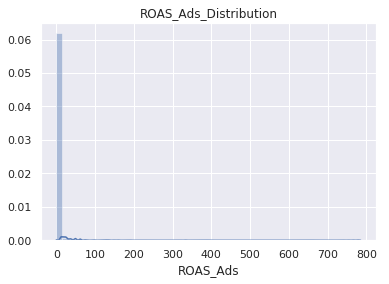

In [29]:
#plot distribution of ROAS_Ads
sns.distplot(df['ROAS_Ads']).set_title('ROAS_Ads_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['ROAS_Ads'].skew(),2)))
print('Kurtosis: {}'.format(round(df['ROAS_Ads'].kurt(),2)))

Skewness: 4.79
Kurtosis: 30.02


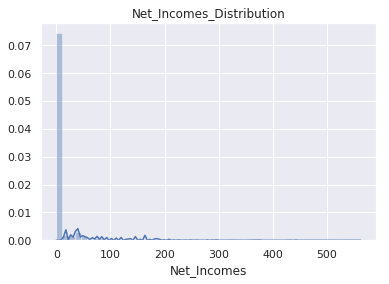

In [30]:
#plot distribution of Net_Incomes
sns.distplot(df['Net_Incomes']).set_title('Net_Incomes_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Net_Incomes'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Net_Incomes'].kurt(),2)))

Apply a filter for selecting features over fixed values of skewness and kurtosis

In [31]:
#filter columns that not accomplish the requirements
df_log = df_concat[(df_concat['Skewness']>=3) | (df_concat['Kurtosis']>=4)]

#show the selection
df_log

,Index,Skewness,Kurtosis
5,Impressions,3.24,17.03
6,Impressions_1w,2.60,8.73
7,Impressions_2w,2.45,7.23
8,Impressions_3w,2.39,6.56
9,Impressions_4w,2.35,6.13
10,Clics,3.35,17.23
11,Clics_1w,2.61,8.24
12,Clics_2w,2.49,7.28
13,Clics_3w,2.45,7.07
14,Clics_4w,2.44,7.02


In [32]:
print('{} features achieve the requirements score of skewness and kurtosis'.format(len(df_concat) - len(df_log)))

7 features achieve the requirements score of skewness and kurtosis


<a name='logarithm_columns'></a>
### Logarithm to numerical features

RELLENAR!

In [33]:
#apply string to index
lista = df_log['Index'].apply(str)

#create a list
c = lista.values.tolist()

#apply log to the list in order to create new columns and drop prevoius features
for col in c:
    df[col+'_log'] = np.log(df[col])
    df.drop([col], axis= 1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6338 entries, 129 to 209
Data columns (total 66 columns):
CatN1                     6338 non-null object
CatN2                     6338 non-null object
Cat_Price                 6338 non-null category
CPC_medio                 6338 non-null float64
CPC_medio_1w              6338 non-null float64
CPC_medio_2w              6338 non-null float64
CPC_medio_3w              6338 non-null float64
CPC_medio_4w              6338 non-null float64
percentile                6338 non-null float64
CTR_log                   6338 non-null float64
Impressions_log           6338 non-null float64
Impressions_1w_log        6338 non-null float64
Impressions_2w_log        6338 non-null float64
Impressions_3w_log        6338 non-null float64
Impressions_4w_log        6338 non-null float64
Clics_log                 6338 non-null float64
Clics_1w_log              6338 non-null float64
Clics_2w_log              6338 non-null float64
Clics_3w_log              633

After applying logarithm to the selected columns, it is shown the new scores of skewness and kurtosis of all columns.

In [35]:
#select index numerical columns
numerical_columns_index_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data_log = pd.DataFrame([])

for col in numerical_columns_index_log:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col].fillna(0, inplace = True)
    data_log = data_log.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                             'Kurtosis': round(df[col].kurt(),2)}, 
                                            index=[0]), ignore_index=True)

#filter numerical columns
numerical_columns_dist_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist_log = pd.DataFrame({'Index':numerical_columns_dist_log.index, 
                                    'Values':numerical_columns_dist_log.values})    
    
#concat both dataframes by index
df_concat_log = pd.concat([df_columns_dist_log['Index'], data_log], 1)

#show the values
df_concat_log

,Index,Skewness,Kurtosis
0,CPC_medio,0.67,2.33
1,CPC_medio_1w,-0.07,-0.11
2,CPC_medio_2w,-0.22,-0.35
3,CPC_medio_3w,-0.28,-0.48
4,CPC_medio_4w,-0.30,-0.61
5,percentile,-0.00,-1.21
6,CTR_log,2.02,3.52
7,Impressions_log,-0.59,0.81
8,Impressions_1w_log,-0.90,2.31
9,Impressions_2w_log,-1.10,3.15


Display again a couple of examples after that change

Skewness: 4.02
Kurtosis: 17.85


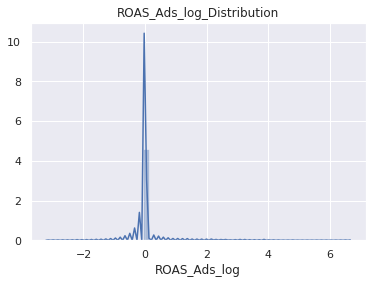

In [36]:
#plot distribution of ROAS_Ads
sns.distplot(df['ROAS_Ads_log']).set_title('ROAS_Ads_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['ROAS_Ads_log'].skew(),2)))
print('Kurtosis: {}'.format(round(df['ROAS_Ads_log'].kurt(),2)))

Skewness: 2.0
Kurtosis: 2.32


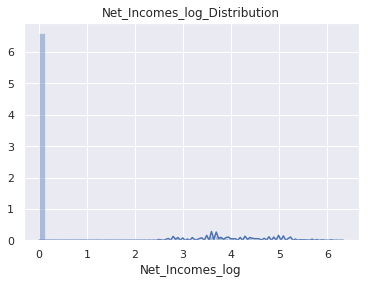

In [37]:
#plot distribution of ROAS_Ads
sns.distplot(df['Net_Incomes_log']).set_title('Net_Incomes_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Net_Incomes_log'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Net_Incomes_log'].kurt(),2)))

<a name='relation_numerical_columns'></a>
## Distribution of numerical features with target variable

RELLENAR


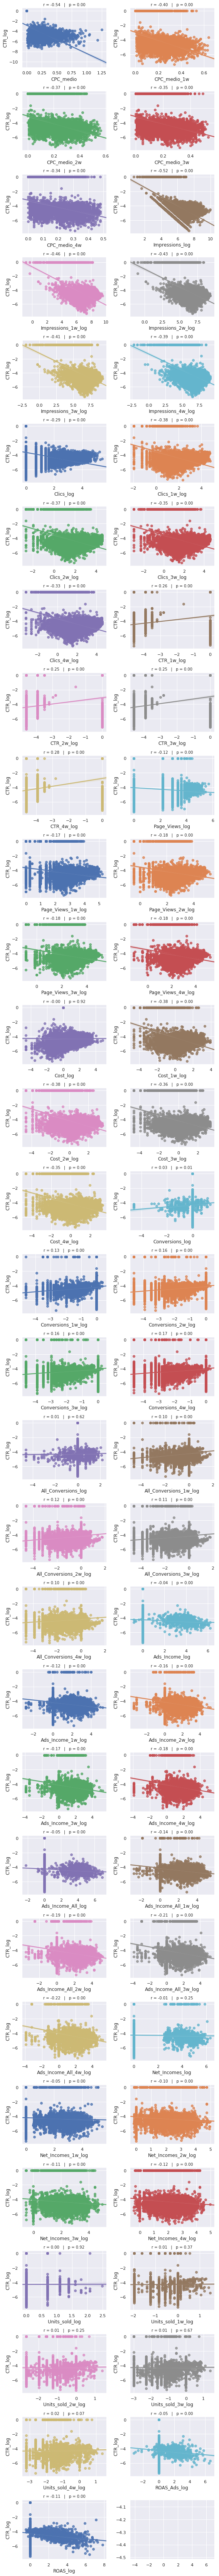

In [38]:
#number of rows and columns
number_rows = 31
number_cols = 2

#set target
y_df = 'CTR_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['CTR_log', 'percentile']
li_plot_num_feats = [c for c in list(numerical_columns_index_log) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

----------

PODEMOS CONCLUIR SOBRE ESTE GRÁFICO

ADEMAS, DEBEMOS HACER QUE SE VEA , NO TENER QUE DESLIZAR

--------

<a name='relation_categorical_columns'></a>
## Distribution of categorical features with target variable

RELLENAR

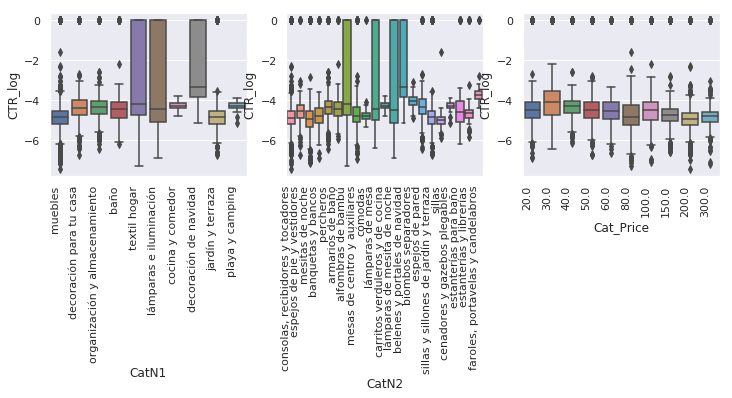

In [39]:
#select categorical columns
categorical_columns_index_log = df.dtypes[(df.dtypes == 'object') | (df.dtypes == 'category')].index

#set number of columns and rows
number_rows = 1
number_cols = 3

#establish target
y_df = 'CTR_log'

#set parameters
li_cat_columns = list(categorical_columns_index_log)

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3), squeeze=False)

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_cat_columns):
            g = sns.boxplot(x = li_cat_columns[f], y = y_df, data = df, ax = axs[r][c])
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')

#show
plt.tight_layout()    
plt.show()

-----------------------------------------------------------------------------------
<a name='data_wrangling'></a>
# Data wrangling

RELLENAR

<a name='data_correlation'></a>
## Correlation

RELLENAR

<a name='data_correlation_numerical_original'></a>
### Correlation of numerical features to target variable

It is measured the correlation of numerical features to target ROAS_log

In [40]:
#drop percentile column
df.drop('percentile', axis=1, inplace=True)


#correlations of numerical features
df.corr()['CTR_log'].sort_values()

CPC_medio                -0.541645
Impressions_log          -0.523757
Impressions_1w_log       -0.455622
Impressions_2w_log       -0.427882
Impressions_3w_log       -0.407444
CPC_medio_1w             -0.400315
Impressions_4w_log       -0.394605
Cost_1w_log              -0.380157
Clics_1w_log             -0.379232
Cost_2w_log              -0.377420
CPC_medio_2w             -0.370941
Clics_2w_log             -0.365933
Cost_3w_log              -0.362764
CPC_medio_3w             -0.353888
Cost_4w_log              -0.351422
Clics_3w_log             -0.346551
CPC_medio_4w             -0.336992
Clics_4w_log             -0.334489
Clics_log                -0.290165
Ads_Income_All_4w_log    -0.216383
Ads_Income_All_3w_log    -0.205676
Ads_Income_All_2w_log    -0.192014
Ads_Income_4w_log        -0.177855
Page_Views_4w_log        -0.176512
Page_Views_2w_log        -0.175715
Page_Views_3w_log        -0.175672
Page_Views_1w_log        -0.169934
Ads_Income_3w_log        -0.166460
Ads_Income_2w_log   

<a name='data_correlation_categorical_original'></a>
### Correlation of categorical features to target variable

First of all, it is applied one-hot encoding to the categorical values

In [41]:
#cat price to string
df['Cat_Price'] = df['Cat_Price'].astype(str)

#select categorical columns
df_categorical = df.select_dtypes('object')

#one-hot encoding of these columns
df_categorical = pd.get_dummies(df_categorical, prefix_sep= '_')

#append CTR_log to dataframe
df_categorical['CTR_log'] = df['CTR_log']
df_categorical.head()

,CatN1_baño,CatN1_cocina y comedor,CatN1_decoración de navidad,CatN1_decoración para tu casa,CatN1_jardín y terraza,CatN1_lámparas e iluminación,CatN1_muebles,CatN1_organización y almacenamiento,CatN1_playa y camping,CatN1_textil hogar,CatN2_alfombras de bambú,CatN2_armarios de baño,CatN2_banquetas y bancos,CatN2_belenes y portales de navidad,CatN2_biombos separadores,CatN2_carritos verduleros y de cocina,CatN2_cenadores y gazebos plegables,"CatN2_consolas, recibidores y tocadores",CatN2_cómodas,CatN2_espejos de pared,CatN2_espejos de pie y vestidores,CatN2_estanterías para baño,CatN2_estanterías y librerías,"CatN2_faroles, portavelas y candelabros",CatN2_lámparas de mesa,CatN2_lámparas de mesita de noche,CatN2_mesas de centro y auxiliares,CatN2_mesitas de noche,CatN2_percheros,CatN2_sillas,CatN2_sillas y sillones de jardín y terraza,Cat_Price_100.0,Cat_Price_150.0,Cat_Price_20.0,Cat_Price_200.0,Cat_Price_30.0,Cat_Price_300.0,Cat_Price_40.0,Cat_Price_50.0,Cat_Price_60.0,Cat_Price_80.0,CTR_log
129,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
130,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
131,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
132,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
133,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0


It is measured the correlation of categorical features to target ROAS_log

In [42]:
#correlation of categorical features
df_categorical.corr()['CTR_log'].sort_values()

CatN1_muebles                                 -0.234842
CatN2_consolas, recibidores y tocadores       -0.140750
Cat_Price_200.0                               -0.140446
CatN2_mesitas de noche                        -0.074707
CatN2_sillas                                  -0.064321
Cat_Price_150.0                               -0.058647
Cat_Price_300.0                               -0.052467
CatN2_mesas de centro y auxiliares            -0.051879
CatN2_cómodas                                 -0.050899
CatN1_jardín y terraza                        -0.045551
CatN2_sillas y sillones de jardín y terraza   -0.045551
CatN2_espejos de pie y vestidores             -0.039972
Cat_Price_80.0                                -0.036913
CatN2_banquetas y bancos                      -0.034395
CatN2_estanterías y librerías                 -0.019700
Cat_Price_60.0                                -0.014169
CatN1_decoración para tu casa                 -0.004502
CatN1_playa y camping                         -0

In [43]:
df.drop('CTR_2w_log', axis=1, inplace=True)
df.drop('CTR_3w_log', axis=1, inplace=True)
df.drop('CTR_4w_log', axis=1, inplace=True)
df.drop('CTR_1w_log', axis=1, inplace=True)

<a name='data_feature_selection'></a>
## Feature Selection

RELLENAR


**Why should it be applied feature selection to this dataset?**
    * It enables the machine learning algorithm to train faster.
    * It reduces the complexity of a model and makes it easier to interpret.
    * It improves the accuracy of a model if the right subset is chosen.
    * It reduces overfitting.
    
    #meter fuente
    https://datascientistssite.wordpress.com/2017/08/21/univariate-selection-feature-in-python/

First of all, it is necessary to make one-hot encoding for categorical features, but in this case, applying and saving the values at the same dataframe as numerical columns.

In [44]:
#one-hot encoding of these columns
df_all = pd.get_dummies(df, prefix_sep = '_')

#columns to list
columns = df_all.columns.tolist()
columns.remove('CTR_log')

#set X and y
X = df_all[columns]

y = df_all.CTR_log

#X columns to list
feature_name = X.columns.tolist()

<a name='data_pearson'></a>
### Pearson

RELLENAR


In [45]:
#apply pearson function
corr_support, corr_feature = pearson_selector(feature_name, X, y)

#print result
print('The number of selected features is {}'.format(str(len(corr_feature))))

The number of selected features is 15


EXPLICAR

<a name='data_random_forest'></a>
### Random Forest

RELLENAR

In [46]:
#apply random forest
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=15), threshold='5*median')

#fit
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='5*median')

In [47]:
#support
embeded_rf_support = embeded_rf_selector.get_support()

#list
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
#print(str(len(embeded_rf_feature)), 'selected features')

#print result
print('The number of selected features is {}'.format(str(len(embeded_rf_feature))))

The number of selected features is 9


EXPLICAR

<a name='data_LGBMRegressor'></a>
### LGBMRegressor

RELLENAR

In [48]:
#apply LGBMRegressor
lgbc= LGBMRegressor(n_estimators=30, learning_rate=0.05, num_leaves=25, colsample_bytree=0.3,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=5)

#set parameters to selector
embeded_lgb_selector = SelectFromModel(lgbc, threshold='10*median')

#fit
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=5, min_split_gain=0.01,
       n_estimators=30, n_jobs=-1, num_leaves=25, objective=None,
       random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=None, norm_order=1, prefit=False,
        threshold='10*median')

In [49]:
#support
embeded_lgb_support = embeded_lgb_selector.get_support()

#list
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

#print(str(len(embeded_lgb_feature)), 'selected features')
#print result
print('The number of selected features is {}'.format(str(len(embeded_lgb_feature))))

The number of selected features is 12


EXPLICAR

<a name='data_final_feature_selection'></a>
### Final Feature Selection

RELLENAR



In [50]:
#all selection in a dataframe
feature_selection = pd.DataFrame({'Feature':feature_name, 
                                  'Pearson':corr_support, 
                                  'Random Forest':embeded_rf_support, 
                                  'LightGBM':embeded_lgb_support})

#count
feature_selection['Total'] = np.sum(feature_selection, axis=1)

#print
feature_selection = feature_selection.sort_values(['Total','Feature'] , ascending=False)
feature_selection.index = range(1, len(feature_selection)+1)
feature_selection.head(50)

,Feature,Pearson,Random Forest,LightGBM,Total
1,Impressions_log,True,True,True,3
2,Impressions_4w_log,True,True,True,3
3,Impressions_1w_log,True,True,True,3
4,CPC_medio,True,True,True,3
5,Impressions_3w_log,True,False,True,2
6,Impressions_2w_log,True,False,True,2
7,Cost_log,False,True,True,2
8,Cost_4w_log,True,True,False,2
9,Clics_log,False,True,True,2
10,Clics_2w_log,True,False,True,2


We select Top 29 columns: del 10 al 29 tienen 1

In [51]:
#filter of Total = 2 
columns_select_final = feature_selection [feature_selection['Total'] >= 2]

#select features
columns_selection = columns_select_final['Feature']

#apply to dataframe
df_final = df_all[columns_selection]

#head
df_final.head()

,Impressions_log,Impressions_4w_log,Impressions_1w_log,CPC_medio,Impressions_3w_log,Impressions_2w_log,Cost_log,Cost_4w_log,Clics_log,Clics_2w_log,Clics_1w_log,CPC_medio_1w
129,2.079442,-1.237874,0.131028,0.0,-0.967584,-0.562119,0.0,0.0,0.0,0.0,0.0,0.0
130,3.988984,0.792993,2.181547,0.0,1.081805,1.488400,0.0,0.0,0.0,0.0,0.0,0.0
131,3.931826,1.396245,2.781301,0.0,1.682688,2.088153,0.0,0.0,0.0,0.0,0.0,0.0
132,3.555348,1.665818,3.051167,0.0,1.953028,2.358020,0.0,0.0,0.0,0.0,0.0,0.0
133,3.091042,1.803359,3.190065,0.0,2.091864,2.496506,0.0,0.0,0.0,0.0,0.0,0.0


Check the data

In [52]:
df_final.shape

(6338, 12)

In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6338 entries, 129 to 209
Data columns (total 12 columns):
Impressions_log       6338 non-null float64
Impressions_4w_log    6338 non-null float64
Impressions_1w_log    6338 non-null float64
CPC_medio             6338 non-null float64
Impressions_3w_log    6338 non-null float64
Impressions_2w_log    6338 non-null float64
Cost_log              6338 non-null float64
Cost_4w_log           6338 non-null float64
Clics_log             6338 non-null float64
Clics_2w_log          6338 non-null float64
Clics_1w_log          6338 non-null float64
CPC_medio_1w          6338 non-null float64
dtypes: float64(12)
memory usage: 803.7 KB


<a name='outliers'></a>
## Outliers

#RELLENAR

Outliers exists in our dataset because of variability of the data.

In [54]:
#introduce log
df_final['CTR_log'] = df['CTR_log']
df_final['CTR_log'] = y

#index dtypes 
numerical_columns_selection = df_final.dtypes.index

#create empty dataframe
data_IQR = pd.DataFrame([])

#calculate IQR for each feature
for col in numerical_columns_selection:
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    data_IQR = data_IQR.append(pd.DataFrame({'IQR': round(Q3 - Q1,2)}, index=[0]), ignore_index=True)

RELLENAR!

In [55]:
#dictionary dtypes
numerical_columns_selection_final = df_final.dtypes

#dataframe
numerical_columns_selection_final = pd.DataFrame({'Index':numerical_columns_selection_final.index, 
                                    'Values':numerical_columns_selection_final.values})   

RELLENAR!

In [56]:
#concat dataframes
df_concat_IQR = pd.concat([numerical_columns_selection_final['Index'], data_IQR], 1)
df_concat_IQR

,Index,IQR
0,Impressions_log,1.56
1,Impressions_4w_log,1.40
2,Impressions_1w_log,1.43
3,CPC_medio,0.15
4,Impressions_3w_log,1.41
5,Impressions_2w_log,1.42
6,Cost_log,1.47
7,Cost_4w_log,1.66
8,Clics_log,2.08
9,Clics_2w_log,1.67


Apply IQR to the dataset

In [57]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = round(Q3 - Q1,2)

df_final = df_final[~((df_final < (Q1 - 1.5 * IQR)) | (df_final > (Q3 + 1.5 * IQR))).any(axis=1)]

In [58]:
df_final.shape

(5176, 13)

<a name='correlation_feature_selection'></a>
## Correlation feature selection

#RELLENAR

In [59]:
df_final.corr()['CTR_log'].sort_values()

CPC_medio_1w         -0.124938
CPC_medio            -0.090586
Impressions_log      -0.080430
Impressions_4w_log   -0.071949
Impressions_3w_log   -0.062499
Impressions_2w_log   -0.056836
Impressions_1w_log   -0.048736
Cost_4w_log           0.128476
Clics_2w_log          0.212208
Clics_1w_log          0.241790
Cost_log              0.390870
Clics_log             0.450059
CTR_log               1.000000
Name: CTR_log, dtype: float64

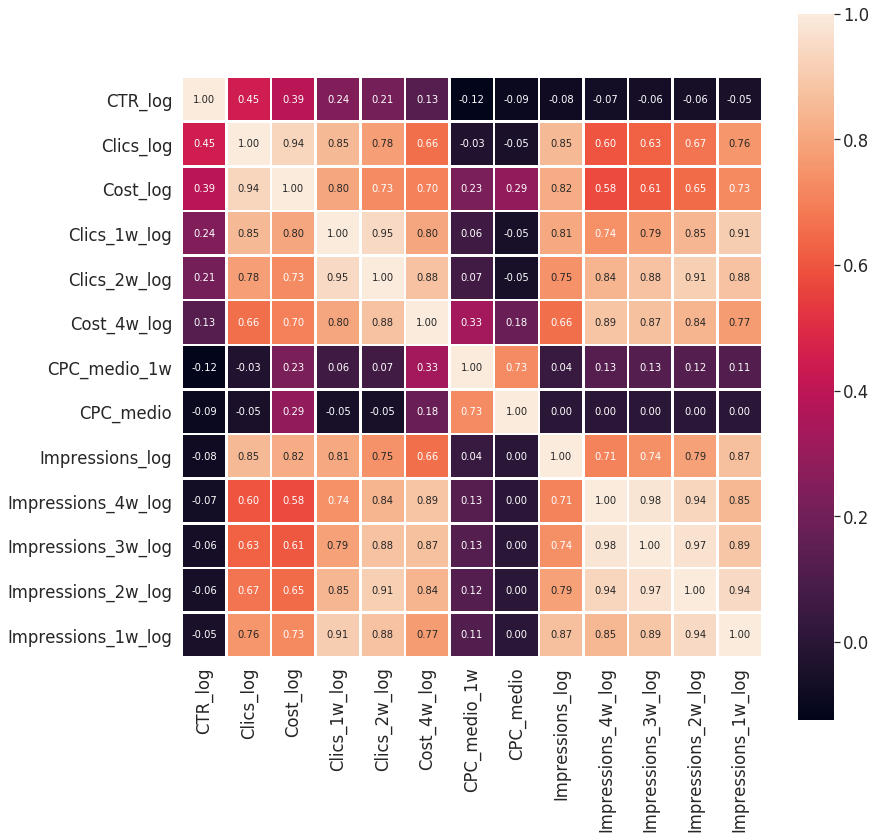

In [60]:
#length columns
number_columns = len(df_final.columns)

#heatmap
plot_correlation_heatmap(df_final, number_columns, "CTR_log")

<a name='distribution_feature_selection'></a>
## Distribution of feature selection with target

#RELLENAR

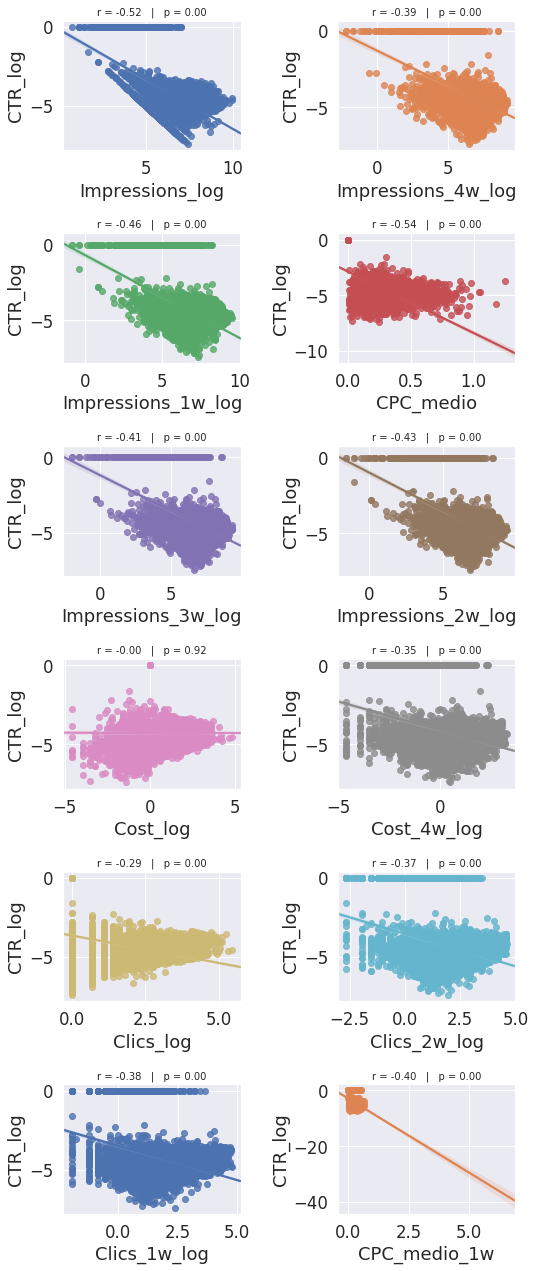

In [61]:
#select index numerical columns
columns_dtypes = df_final.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'CTR_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['CTR_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

<a name='multicollinearity'></a>
## Multicollinearity

RELLENAR

In [63]:
#save correlation
corr_final = df_final.corr()['CTR_log'].sort_values()

#correlation to dataframe
df_corr_final = pd.DataFrame({'Index':corr_final.index, 'Values':abs(corr_final.values)}) 
df_corr_final

#split the index
df_corr_final[['First', 'Second', 'Third']] = df_corr_final['Index'].str.rsplit("_", n = 2, expand=True)

#sort values
df_corr_final = df_corr_final.sort_values(by = 'Values', ascending = False)

#groupby
df_groupby = df_corr_final.groupby('First').first()

#select column
columns_groupby = ['First', 'Index', 'Values']

#display
df_groupby.reset_index(inplace = True)
df_groupby = df_groupby[columns_groupby]
df_groupby

,First,Index,Values
0,CPC,CPC_medio_1w,0.124938
1,CTR,CTR_log,1.000000
2,Clics,Clics_log,0.450059
3,Cost,Cost_log,0.390870
4,Impressions,Impressions_log,0.080430


In [64]:
#save features selected as columns
df_columns_list = df_groupby.Index.values.tolist()

#select columns
df_columns_list

#save data
df_all = df_final[df_columns_list]

Check dataset

In [65]:
df_all.head()

,CPC_medio_1w,CTR_log,Clics_log,Cost_log,Impressions_log
145,0.23,-5.318120,0.000000,-0.616186,5.318120
148,0.33,-3.610918,1.098612,-0.755023,4.709530
149,0.30,-3.772761,0.693147,-1.386294,4.465908
153,0.08,-3.238678,1.386294,-0.174353,4.624973
156,0.20,-4.436752,0.693147,-0.579818,5.129899


In [66]:
df_all.shape

(5176, 5)

In [67]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 145 to 209
Data columns (total 5 columns):
CPC_medio_1w       5176 non-null float64
CTR_log            5176 non-null float64
Clics_log          5176 non-null float64
Cost_log           5176 non-null float64
Impressions_log    5176 non-null float64
dtypes: float64(5)
memory usage: 242.6 KB


<a name='standardscaler'></a>
## StandardScaler

#EXPLICAR POR QUE ESCALAR

In [68]:
#apply standardscaler
sc = StandardScaler()
df_all_sc = sc.fit_transform(df_all)

#final dataset
df_all_sc = pd.DataFrame(df_all_sc)

#rename columns
df_all_sc.columns = df_columns_list

Check the data

In [69]:
df_all_sc.head(5)

,CPC_medio_1w,CTR_log,Clics_log,Cost_log,Impressions_log
0,-0.377779,-1.101243,-2.016472,-1.236966,-1.608989
1,0.729962,1.940187,-0.994582,-1.358074,-2.240854
2,0.397640,1.651859,-1.371731,-1.908736,-2.493793
3,-2.039392,2.603343,-0.726991,-0.851553,-2.328645
4,-0.710102,0.468941,-1.371731,-1.205242,-1.804409


In [70]:
df_all_sc.shape

(5176, 5)

In [71]:
df_all_sc.describe()

,CPC_medio_1w,CTR_log,Clics_log,Cost_log,Impressions_log
count,5.176000e+03,5.176000e+03,5.176000e+03,5.176000e+03,5.176000e+03
mean,1.098211e-16,1.240979e-15,3.624097e-16,2.196423e-17,6.369626e-16
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00
min,-2.704037e+00,-2.971968e+00,-2.016472e+00,-2.624882e+00,-3.469272e+00
25%,-5.993276e-01,-6.323136e-01,-7.269906e-01,-6.569032e-01,-6.954904e-01
50%,-4.545679e-02,1.620691e-02,2.730760e-02,6.784061e-02,-3.108797e-03
75%,6.191882e-01,6.820724e-01,7.223397e-01,7.079416e-01,6.808535e-01
max,2.945446e+00,3.325691e+00,2.732896e+00,2.457640e+00,2.766862e+00


<a name='grade_percentile_target'></a>
## Grade Percentile of target variable

#RELLENAR

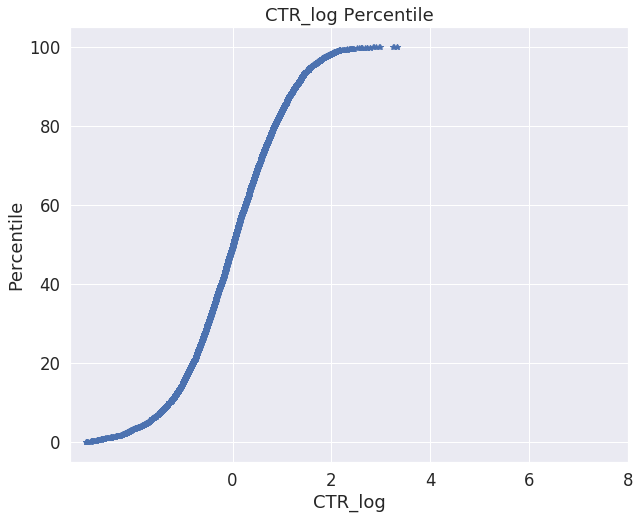

In [72]:
#create percentile
df_all_sc['percentile'] = df_all_sc['CTR_log'].apply(lambda x: percentileofscore(df_all_sc['CTR_log'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df_all_sc['CTR_log'], df_all_sc['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('CTR_log')
plt.ylabel('Percentile')
plt.title('CTR_log Percentile');

In [74]:
print('Score 50th percentile: {}'.format(round(np.min(df_all_sc.loc[df_all_sc['percentile'] > 50, 'CTR_log']),2)))
print('Score 90th percentile: {}'.format(round(np.min(df_all_sc.loc[df_all_sc['percentile'] > 90, 'CTR_log']),2)))

Score 50th percentile: 0.02
Score 90th percentile: 1.28


<a name='distribution_final_dataset'></a>
## Correlation and Distribution final dataset

RELLENAR

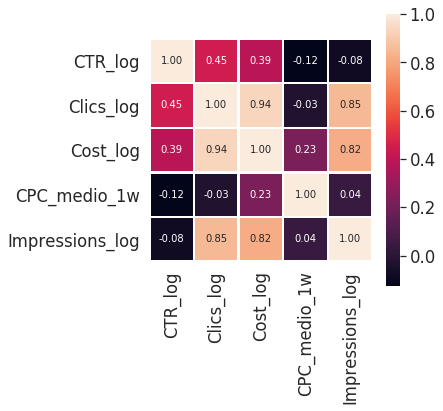

In [77]:
#remove percentile feature
#df_all_sc.drop('percentile', axis=1, inplace=True)

#length columns
number_columns = len(df_all_sc.columns)

#heatmap
plot_correlation_heatmap(df_all_sc, number_columns, "CTR_log")

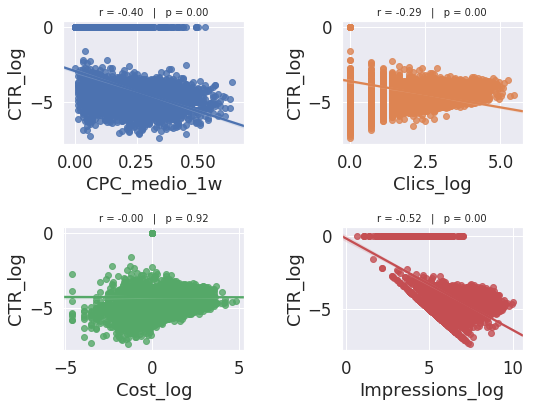

In [78]:
#select index numerical columns
columns_dtypes = df_all_sc.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'CTR_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['CTR_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

<a name='regression_models'></a>
# Regression Models

In [79]:
#to list
df_regression_columns = df_all_sc.columns.tolist()

#create X variable
X = df_all_sc[df_regression_columns]

#drop CTR from X
#remove percentile feature
X.drop('CTR_log', axis=1, inplace=True)

#create y variable
y = df_all_sc['CTR_log']

In [80]:
X.head()

,CPC_medio_1w,Clics_log,Cost_log,Impressions_log
0,-0.377779,-2.016472,-1.236966,-1.608989
1,0.729962,-0.994582,-1.358074,-2.240854
2,0.397640,-1.371731,-1.908736,-2.493793
3,-2.039392,-0.726991,-0.851553,-2.328645
4,-0.710102,-1.371731,-1.205242,-1.804409


In [81]:
y.head()

0   -1.101243
1    1.940187
2    1.651859
3    2.603343
4    0.468941
Name: CTR_log, dtype: float64

In [82]:
y.describe()

count    5.176000e+03
mean     1.240979e-15
std      1.000097e+00
min     -2.971968e+00
25%     -6.323136e-01
50%      1.620691e-02
75%      6.820724e-01
max      3.325691e+00
Name: CTR_log, dtype: float64

We test the following Regressors from scikit-learn:
    - LinearRegression
    - KNN Regressor
    - Ridge
    - Lasso
    - Elastic Net
    - SGDRegressor
    - Gradient Boosting Descent
    - Decision Tree Regressor
    - Random Forest Regressor

In [83]:
score_calc = 'neg_mean_squared_error'
scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'rsquared':'r2'}

# mirar si hacemos predict

<a name='knn'></a>
## KNeighbors Regressor

RELLENAR

In [84]:
#apply grid search
reg_knn_gs = GridSearchCV(KNeighborsRegressor(),
            param_grid = {"n_neighbors":np.arange(4,100)},
            cv = nr_cv,
            scoring = score_calc)
    
#fit
reg_knn_gs.fit(X,y)
    
#get best params
knn_best_params = reg_knn_gs.best_params_.get('n_neighbors')
    
#apply knn to best params
reg_knn = KNeighborsRegressor(n_neighbors = knn_best_params)
    
#cross validation
scores = cross_validate(reg_knn, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)
    
#saves scores
knn_mae = abs(scores['test_abs_error'].mean())
knn_rmse = math.sqrt(abs(scores['test_squared_error'].mean()))
knn_r2 = abs(scores['test_rsquared'].mean())

<a name='mlr'></a>
## Linear Regression

RELLENAR

In [85]:
np.log(0)

-inf

In [86]:
#apply linear regression with grid search
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = nr_cv, verbose = 1 , scoring = score_calc)

#fit
grid_linear.fit(X, y)

#get best params
#mlr_best_params = grid_linear.best_params_

#aply linear regression with best params
reg_mlr = LinearRegression(grid_linear.best_params_)

#cross validation
scores_mlr = cross_validate(reg_mlr, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
mlr_mae = abs(scores_mlr['test_abs_error'].mean())
mlr_rmse = math.sqrt(abs(scores_mlr['test_squared_error'].mean()))
mlr_r2 = abs(scores_mlr['test_rsquared'].mean())

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished


In [87]:
grid_linear.best_score_

-2.0123240099519712e-30

In [88]:
mlr_r2

1.0

In [89]:
mlr_rmse

1.4186467543866394e-15

In [90]:
mlr_r2

1.0

<a name='ridge'></a>
## Ridge

RELLENAR

In [91]:
#apply ridge with grid search 
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv= nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_ridge.fit(X, y)

#save best params values as list
ridge_best_params_list = list(grid_ridge.best_params_.values())

##apply ridge with best params
ridge_best_params = Ridge(alpha = ridge_best_params_list[0], 
                          normalize = ridge_best_params_list[1], 
                          tol= ridge_best_params_list[2])

#cross validation
scores_ridge = cross_validate(ridge_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
ridge_mae = abs(scores_ridge['test_abs_error'].mean())
ridge_rmse = math.sqrt(abs(scores_ridge['test_squared_error'].mean()))
ridge_r2 = abs(scores_ridge['test_rsquared'].mean())

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    1.4s finished


<a name='lasso'></a>
## Lasso

RELLENAR

In [92]:
#apply lasso with grid search
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 
              'normalize':[True,False], 
              'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1, scoring = score_calc)

#fit
grid_lasso.fit(X, y)

#save best params values as list
lasso_best_params_list = list(grid_lasso.best_params_.values())

#apply lasso with best params
reg_lasso = Lasso(alpha= lasso_best_params_list[0], 
                  normalize= lasso_best_params_list[1],
                  tol= lasso_best_params_list[2])

#cross validation
scores_lasso = cross_validate(reg_lasso, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
lasso_mae = abs(scores_lasso['test_abs_error'].mean())
lasso_rmse = math.sqrt(abs(scores_lasso['test_squared_error'].mean()))
lasso_r2 = abs(scores_lasso['test_rsquared'].mean())

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    4.4s finished


<a name='enet'></a>
## Elastic Net

RELLENAR

In [93]:
#apply elastic net with grid search 
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv = nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_enet.fit(X, y)

#save best params as list
enet_best_params_list = list(grid_enet.best_params_.values())


#apply enet with best params
enet_best_params = ElasticNet(alpha = enet_best_params_list[0], 
                              fit_intercept= enet_best_params_list[1], 
                              l1_ratio= enet_best_params_list[2], 
                              max_iter= enet_best_params_list[3], 
                              normalize= enet_best_params_list[4],
                              tol= enet_best_params_list[5])

#cross validation
scores_enet = cross_validate(enet_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
enet_mae = abs(scores_enet['test_abs_error'].mean())
enet_rmse = math.sqrt(abs(scores_enet['test_squared_error'].mean()))
enet_r2 = abs(scores_enet['test_rsquared'].mean())

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    2.7s finished


<a name='sgd'></a>
## SGD Regressor

In [94]:
#apply sgd regressor with grid search
sgd = SGDRegressor()
parameters = {'max_iter' :[1000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]}
grid_sgd = GridSearchCV(sgd, parameters, cv = nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_sgd.fit(X, y)

#save best params values as list
sgd_best_params_list = list(grid_sgd.best_params_.values())

#apply best params to sgd
sgd = SGDRegressor(alpha = sgd_best_params_list[0], 
                   epsilon = sgd_best_params_list[1], 
                   fit_intercept = sgd_best_params_list[2], 
                   max_iter = sgd_best_params_list[3])

#cross validation
scores_sgd = cross_validate(sgd, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
sgd_mae = abs(scores_sgd['test_abs_error'].mean())
sgd_rmse = math.sqrt(abs(scores_sgd['test_squared_error'].mean()))
sgd_r2 = abs(scores_sgd['test_rsquared'].mean())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


<a name='dtr'></a>
## Decision Tree Regressor

RELLENAR

In [95]:
#apply decision tree with grid search
reg_dtr = GridSearchCV(DecisionTreeRegressor(),
                  param_grid = {"max_depth":np.arange(2,8),
                              "min_samples_leaf":[10,30,50,100]},
                  cv = nr_cv,
                  scoring = "neg_mean_absolute_error")

#fit
reg_dtr.fit(X,y)

#save best params values as a list
dtr_best_params = list(reg_dtr.best_params_.values())

#apply decision tree with best params
reg_dtr = DecisionTreeRegressor(max_depth = dtr_best_params[0], min_samples_leaf = dtr_best_params[1])

#cross validation
scores_dtr = cross_validate(reg_dtr, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
dtr_mae = abs(scores_dtr['test_abs_error'].mean())
dtr_rmse = math.sqrt(abs(scores_dtr['test_squared_error'].mean()))
dtr_r2 = abs(scores_dtr['test_rsquared'].mean())

<a name='gbr'></a>
## Gradient Boosting Regressor

RELLENAR

In [96]:
#apply gradient boosting regressor with gird search
reg_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators = nr_est),
                  param_grid = {"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring = "neg_mean_absolute_error",
                  cv = nr_cv)

#fit
reg_gbr.fit(X,y)

#save best params values as list
gbr_best_params_list = list(reg_gbr.best_params_.values())

#apply gradient boosting regressor with best params
gbr_best_params = GradientBoostingRegressor(max_depth = gbr_best_params_list[1], 
                                            n_estimators= nr_est,
                                            learning_rate = gbr_best_params_list[0])

#cross validation
scores_gbr = cross_validate(gbr_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

#saves scores
gbr_mae = abs(scores_gbr['test_abs_error'].mean())
gbr_rmse = math.sqrt(abs(scores_gbr['test_squared_error'].mean()))
gbr_r2 = abs(scores_gbr['test_rsquared'].mean())

<a name='rfr'></a>
## Random Forest Regressor

RELLENAR

In [97]:
#apply random forest regressor with grid search
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [20,50], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)

#fit
grid_rf.fit(X, y)

#save best params values as list
rfr_best_params_list = list(grid_rf.best_params_.values())

#apply random forest regressor with best params
rfr_best_params = RandomForestRegressor(min_samples_split = rfr_best_params_list[0], 
                                        n_estimators = rfr_best_params_list[1], 
                                        random_state = rfr_best_params_list[2])

#cross validation
scores_rfr = cross_validate(rfr_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
rfr_mae = abs(scores_rfr['test_abs_error'].mean())
rfr_rmse = math.sqrt(abs(scores_rfr['test_squared_error'].mean()))
rfr_r2 = abs(scores_rfr['test_rsquared'].mean())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   14.7s finished


In [98]:
rfr_r2

0.9879700730798296

# Comparison plot

RELLENAR

In [99]:
#list mae
list_mae = [knn_mae, mlr_mae, dtr_mae, gbr_mae,lasso_mae, ridge_mae, enet_mae, sgd_mae, rfr_mae]

#list rmse
list_rmse = [knn_rmse, mlr_rmse, dtr_rmse, gbr_rmse,lasso_rmse, ridge_rmse, enet_rmse,sgd_rmse,rfr_rmse]

#list r squared
list_r2 = [knn_r2, mlr_r2, dtr_r2, gbr_r2,lasso_r2, ridge_r2, enet_r2,sgd_r2,rfr_r2]

#define regressors
list_regressors = ['KNN Regressor','Linear Regression', 'Ridge', 'Lasso', 'ElaNet', 'SGD Regressor', 
                   'DecisionTree Regressor', 'GradientBoosting Regressor', 'RandomForest']

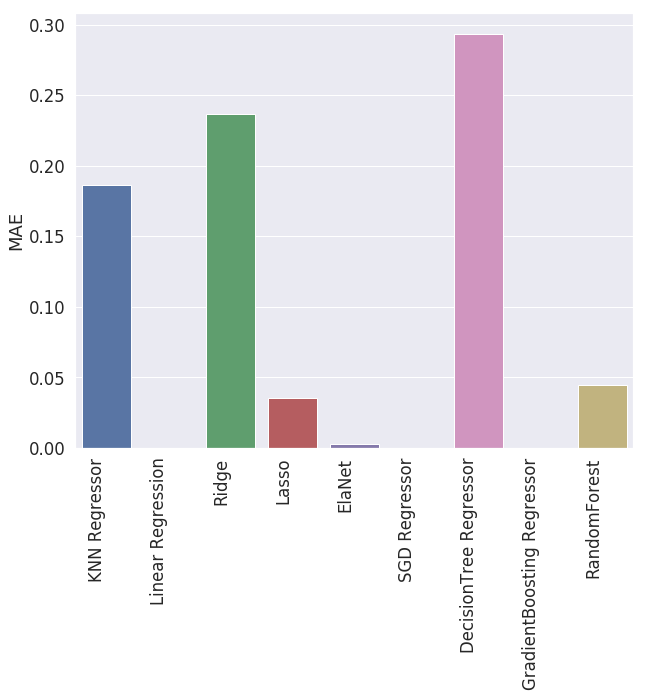

In [102]:
#plot mae 
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
mae_plot = sns.barplot(x = list_regressors, y = list_mae, ax = ax)
mae_plot.set_xticklabels(mae_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('MAE')
plt.show()

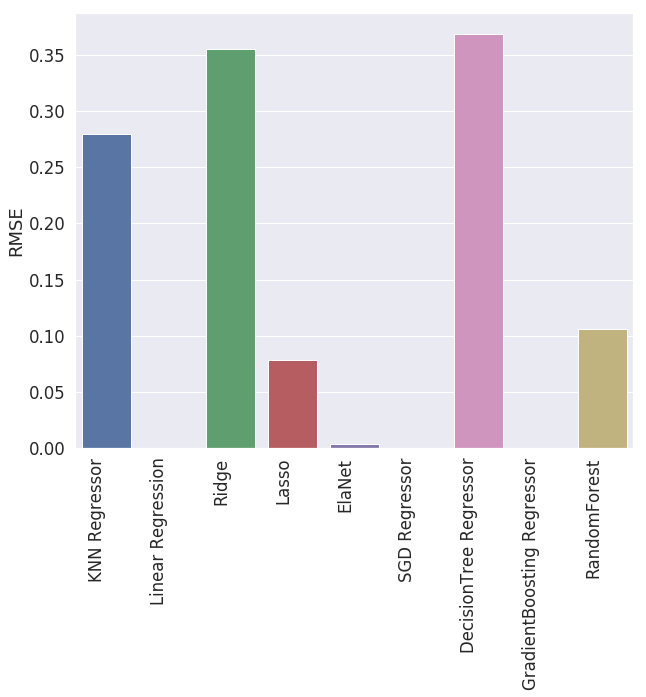

In [103]:
#plot rmse 
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
rmse_plot = sns.barplot(x = list_regressors, y = list_rmse, ax = ax)
rmse_plot.set_xticklabels(rmse_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('RMSE')
plt.show()

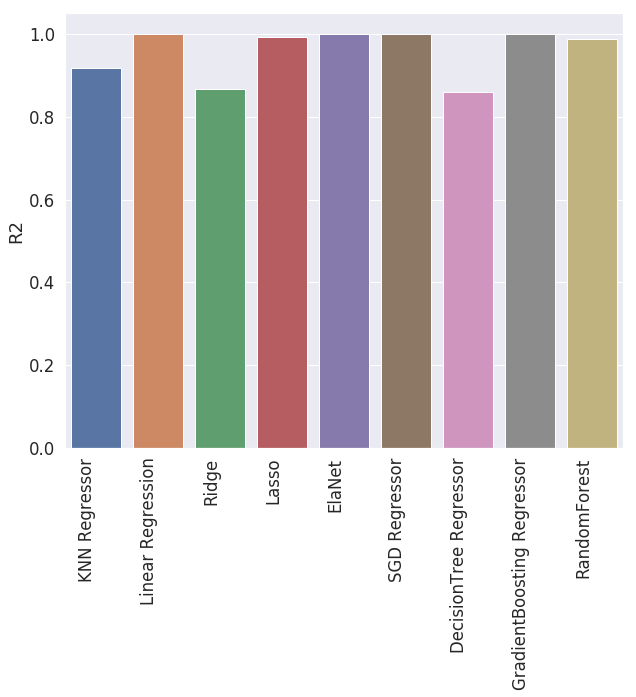

In [104]:
#plot r squared
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
r2_plot = sns.barplot(x = list_regressors, y = list_r2, ax = ax)
r2_plot.set_xticklabels(r2_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('R2')
plt.show()

In [105]:
rfr_best_params.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

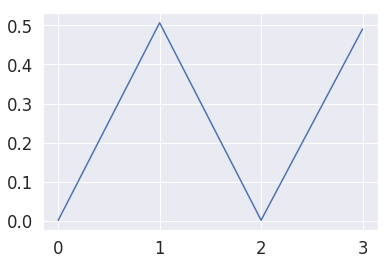

In [106]:
plt.plot(rfr_best_params.feature_importances_)

In [108]:
X.columns[rfr_best_params.feature_importances_>0.01]

Index(['Clics_log', 'Impressions_log'], dtype='object')

In [99]:
# feature importance de categorias
# lo mismo con rolling y sin rolloing